In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import IBMQ
from qiskit import execute
from qiskit import Aer

from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, complete_meas_cal
from qiskit.visualization import plot_histogram

In [1]:
IBMQ.load_account()

In [3]:
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import TruthTableOracle

In [ ]:
def encode_classical_information(x, qr_v, qc):
    Nbits = len(qr_v)
    x_bin = bin(x)[2:].zfill(Nbits)
    for i in range(Nbits):
        if x_bin[Nbits-i-1] == '1':
            qc.x(qr_v[i])
        
    qc.barrier()
    return qc

def measure_output(qr_o, cr_o, qc):
    qc.measure(qr_o[0], cr_o[0])
    
    return qc

# Exercise 8a: An oracle for Grover's algorithm

Let's perform a search in an unordered database using Grover's algorithm. 
Specifically, we search for the element **011** in the set of values of a 3-bit register.
Grover's algorithm needs an oracle function which tells you if a given element is the one we are search for.
If so, the oracle outputs **1**, else, it outputs **0**.
Such an oracle can be specified using the following truth table:
 
 | input 1 | input 2 | input 3 | output |
 |---|---|---|---|
 | 0 | 0 | 0 | **0** |
 | 0 | 0 | 1 | **0** | 
 | 0 | 1 | 0 | **0** | 
 | *0* | *1* | *1* | **1** |
 | 1 | 0 | 0 | **0** |
 | 1 | 0 | 1 | **0** | 
 | 1 | 1 | 0 | **0** | 
 | 1 | 1 | 1 | **0** |
 
Generate an oracle according to this truth table.

Hint: Use the TruthTableOracle function and remember that it is it is sufficient to indicate the **output** row of the truth table.

In [47]:
oracle_3bit = TruthTableOracle('0001000000000000')

Check that the quantum circuit properly implements the truth table given above. 

Hint: You can use the functions *encode_classical_information* and *measure_output* defined above if needed.

Hint: The oracle has a property *variable_register* to access the variable register of the oracle

The TruthTableOracle object calculates the required quantum circuit to implement this truth table for us. Let's have a look at it:

In [48]:
oracle_3bit.circuit.draw()

v_0: ───────■────────
            │        
v_1: ───────■────────
     ┌───┐  │   ┌───┐
v_2: ┤ X ├──■───┤ X ├
     ├───┤  │   ├───┤
v_3: ┤ X ├──■───┤ X ├
     └───┘┌─┴──┐└───┘
o_0: ─────┤0   ├─────
          │    │     
a_0: ─────┤1 X ├─────
          │    │     
a_1: ─────┤2   ├─────
          └────┘

In [51]:
# this allows us to access the oracle's variable_register
oracle_3bit.variable_register

QuantumRegister(4, 'v')

In a first step, we want to check this quantum circuit. 
Therefore, we must apply all four basis states to it and measure the value of the output register. 

In [52]:
def full_circuit(x, oracle):
    qr_v = QuantumRegister(len(oracle.variable_register), 'v')
    qr_o = QuantumRegister(1, 'o')
    cr_o = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr_v, qr_o, cr_o)
    
    return (  encode_classical_information(x, qr_v, qc) 
            + oracle.circuit 
            + measure_output(qr_o, cr_o, qc))

In [58]:
qcs = [ full_circuit(x, oracle_3bit) for x in range(16) ]

Have a look at what we defined:

In [59]:
qcs[7].draw()

┌───┐ ░            ┌───┐      ░    
v_0: ┤ X ├─░────────■───┤ X ├──────░────
     ├───┤ ░        │   ├───┤      ░    
v_1: ┤ X ├─░────────■───┤ X ├──────░────
     ├───┤ ░ ┌───┐  │   ├───┤┌───┐ ░    
v_2: ┤ X ├─░─┤ X ├──■───┤ X ├┤ X ├─░────
     └───┘ ░ ├───┤  │   ├───┤└───┘ ░    
v_3: ──────░─┤ X ├──■───┤ X ├──────░────
           ░ └───┘┌─┴──┐└───┘      ░ ┌─┐
o_0: ──────░──────┤0   ├───────────░─┤M├
           ░      │    │           ░ └╥┘
a_0: ─────────────┤1 X ├──────────────╫─
                  │    │              ║ 
a_1: ─────────────┤2   ├──────────────╫─
                  └────┘              ║ 
c: 1/═════════════════════════════════╩═
                                      0

In [60]:
job = execute(qcs, Aer.get_backend('qasm_simulator'), shots=8192)

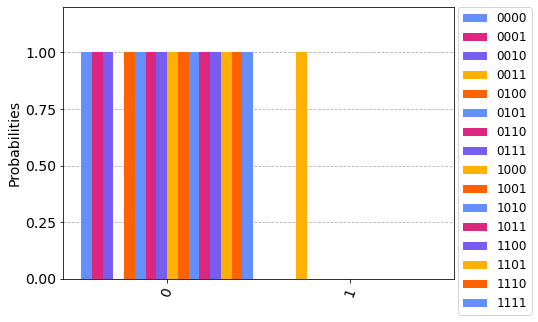

In [61]:
plot_histogram(job.result().get_counts(),
               legend=[str(bin(x))[2:].zfill(4) for x in range(len(qcs))],
               bar_labels=False)

<hr>

# Exercise 8b: Grover's algorithm

Having defined and verified the orcle circuit, let's now perform Grover's algorithm to find the element **011** in the unsorted database. 

The *Grover* class has a method that allows you to compute the optimal number of Grover steps required to find the element. Check what happens if you do more or less Grover steps and try to understand the results.

In [81]:
outs = []
# this is the optimal number of iterations
N_iter_opt = algo_grover.optimal_num_iterations(1, len(oracle_3bit.variable_register))
# we'll do some more to see what happens
for i in range(int(2*N_iter_opt)):
    algo_grover = Grover(oracle_3bit, iterations=i)
    algo_grover.construct_circuit(measurement=True)
    out = algo_grover.run(Aer.get_backend('qasm_simulator'))
    outs += [out]

In [83]:
# inspect the circuits
outs[4]['circuit'].draw()

┌───┐┌────┐┌────┐┌────┐┌────┐┌─┐         
  q_0: ┤ H ├┤0   ├┤0   ├┤0   ├┤0   ├┤M├─────────
       ├───┤│    ││    ││    ││    │└╥┘┌─┐      
  q_1: ┤ H ├┤1   ├┤1   ├┤1   ├┤1   ├─╫─┤M├──────
       ├───┤│    ││    ││    ││    │ ║ └╥┘┌─┐   
  q_2: ┤ H ├┤2   ├┤2   ├┤2   ├┤2   ├─╫──╫─┤M├───
       ├───┤│    ││    ││    ││    │ ║  ║ └╥┘┌─┐
  q_3: ┤ H ├┤3 Q ├┤3 Q ├┤3 Q ├┤3 Q ├─╫──╫──╫─┤M├
       └───┘│    ││    ││    ││    │ ║  ║  ║ └╥┘
  q_4: ─────┤4   ├┤4   ├┤4   ├┤4   ├─╫──╫──╫──╫─
            │    ││    ││    ││    │ ║  ║  ║  ║ 
  q_5: ─────┤5   ├┤5   ├┤5   ├┤5   ├─╫──╫──╫──╫─
            │    ││    ││    ││    │ ║  ║  ║  ║ 
  q_6: ─────┤6   ├┤6   ├┤6   ├┤6   ├─╫──╫──╫──╫─
            └────┘└────┘└────┘└────┘ ║  ║  ║  ║ 
c36: 4/══════════════════════════════╩══╩══╩══╩═
                                     0  1  2  3

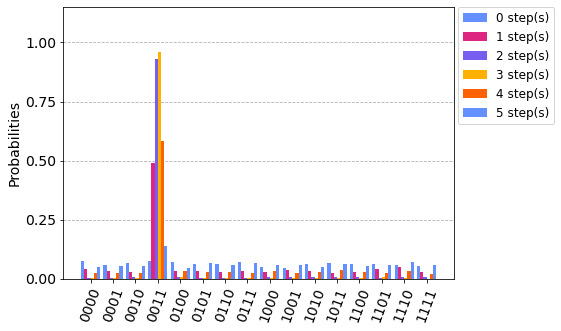

In [90]:
plot_histogram([ out['measurement'] for out in outs], bar_labels=False, 
                 legend=["{} step(s)".format(i) for i in range(len(outs))])

<hr>